In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '안녕',
    '반짝이다',
    '가다'
]

data = np.concatenate([
    np.load('dataset/seq_안녕_1667893661.npy'),
    np.load('dataset/seq_반짝이다_1667893661.npy'),
    np.load('dataset/seq_가다_1667893661.npy'),
], axis=0)

data.shape

(1616, 30, 100)

In [3]:
x_data = data[:, :, :-1] # 마지막 값이 레이블 값이라 해당 값만 빼고 추출
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1616, 30, 99)
(1616,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1616, 3)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1454, 30, 99) (1454, 3)
(162, 30, 99) (162, 3)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'), # LSTM 결과를 Dense에 담음
    Dense(len(actions), activation='softmax')  # 총 액션의 수인 6이 나옴
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44,163
Trainable params: 44,163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


2022-11-08 16:50:43.786149: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/46 [============================>.] - ETA: 0s - loss: 11.0745 - acc: 0.4528
Epoch 1: val_acc improved from -inf to 0.62963, saving model to models/model.h5
46/46 [==============================] - 1s 11ms/step - loss: 11.0121 - acc: 0.4546 - val_loss: 4.6945 - val_acc: 0.6296 - lr: 0.0010
Epoch 2/200
45/46 [============================>.] - ETA: 0s - loss: 8.7404 - acc: 0.6458
Epoch 2: val_acc did not improve from 0.62963
46/46 [==============================] - 0s 8ms/step - loss: 8.8397 - acc: 0.6437 - val_loss: 15.6721 - val_acc: 0.4938 - lr: 0.0010
Epoch 3/200
43/46 [===========================>..] - ETA: 0s - loss: 14.3775 - acc: 0.5785
Epoch 3: val_acc improved from 0.62963 to 0.66667, saving model to models/model.h5
46/46 [==============================] - 0s 10ms/step - loss: 14.9418 - acc: 0.5784 - val_loss: 19.3922 - val_acc: 0.6667 - lr: 0.0010
Epoch 4/200
43/46 [===========================>..] - ETA: 0s - loss: 31.0554 - acc: 0.6156
Epoch 4: val_acc did not improve from 

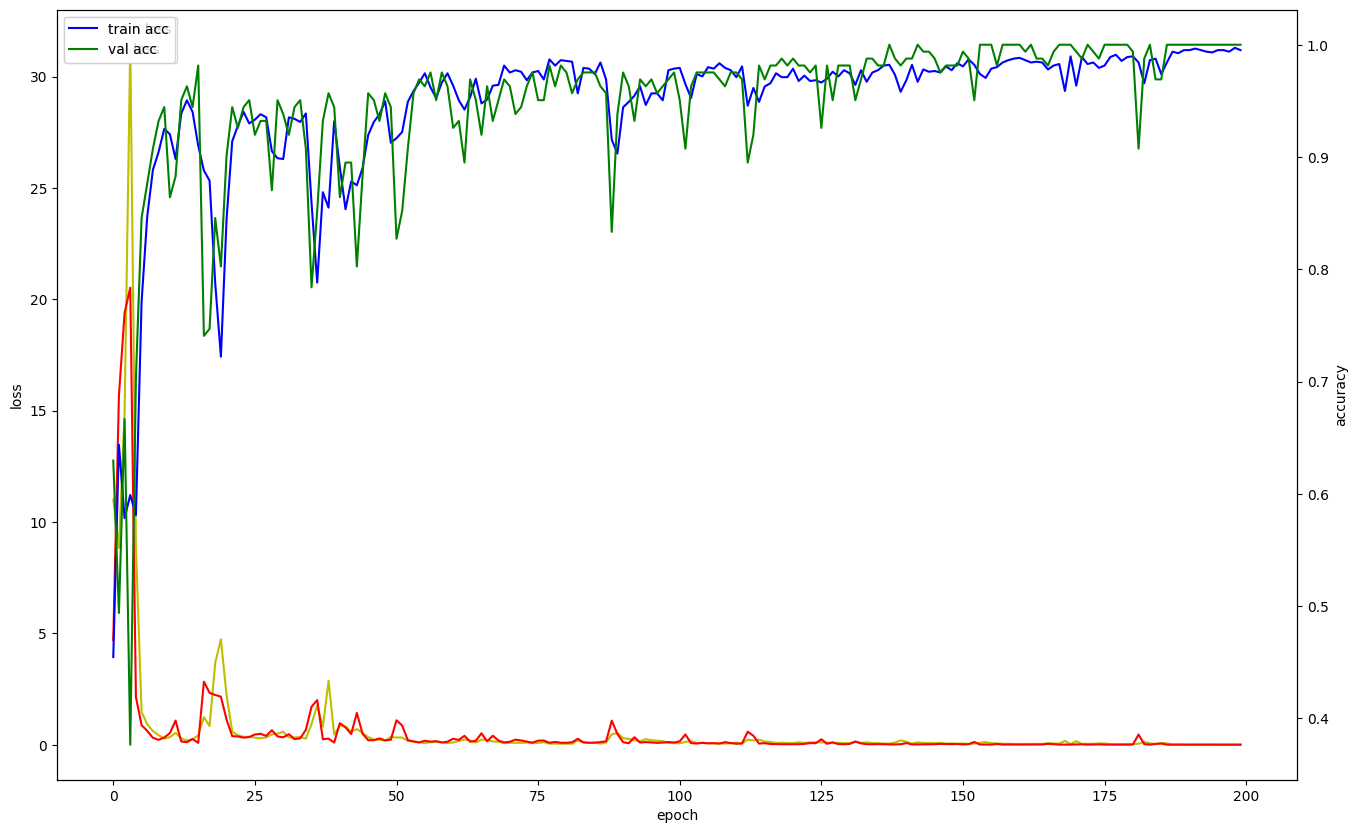

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

6/6 [==============================] - 0s 3ms/step


array([[[ 76,   0],
        [  0,  86]],

       [[126,   0],
        [  0,  36]],

       [[122,   0],
        [  0,  40]]])